In [1]:
# Import necessary components from your module
from ipyleaflet import WidgetControl, ImageOverlay
from hat.mapping.visualisation import GeoJSONLayerManager, InteractiveMap, create_circle_markers, create_gradient_legend, make_line_click_handler, make_style_callback, vector_style, create_polygon_legend
import matplotlib.pyplot as plt
import geopandas as gpd
import xarray as xr
import matplotlib.pyplot as plt
from io import BytesIO
import base64

folder = "~/freelance/02_ort_ecmwf/dev/hat/hat/mapping/station_mapping/"

# Define a colormap and normalization (if needed)
cmap = plt.cm.get_cmap('PRGn')
norm = plt.Normalize(vmin=-10, vmax=10)

gdf_station = gpd.read_file(folder +"stations.geojson")

station_layer = create_circle_markers(gdf_station, 'near2new_distance_km', 0, 'blue', 'black', "Station")
nearest_grid_layer = GeoJSONLayerManager(folder +"near_grid.geojson", 
                                         style_callback=lambda feature: vector_style(feature, 'black', 0.5), 
                                         name="Near Grid")
new_grid_layer = GeoJSONLayerManager(folder +"new_grid.geojson", 
                                     style_callback=lambda feature: vector_style(feature, 'blue', 0.5), 
                                     name="New Grid")
line_new_layer = GeoJSONLayerManager(folder + "station2grid_new_line.geojson", 
                                     style_callback=make_style_callback('new_area_diff', cmap, norm), 
                                     name="New Area Difference")
river_overlay = GeoJSONLayerManager("riv_seq_europe.geojson", 
                                     style_callback=lambda feature: vector_style(feature, 'blue', 0.1), 
                                     name="River Grid")

/tmp/ipykernel_53567/3479748044.py:14: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('PRGn')


DriverError: /home/dadiyorto/freelance/02_ort_ecmwf/dev/hat/hat/mapping/station_mapping/station2grid_new_line.geojson: No such file or directory

In [ ]:
# Create an InteractiveMap instance
my_map = InteractiveMap()
# Add layers to the map
my_map.add_layer(river_overlay)
my_map.map.add_layer(station_layer)
my_map.add_layer(nearest_grid_layer)
my_map.add_layer(new_grid_layer)
my_map.add_layer(line_new_layer)

# Add line click handlers after the layer has been added to the map
if line_new_layer.layer:
    line_new_layer.layer.on_click(
        make_line_click_handler('station_name', 'station_area', 
                                'near_grid_area','new_grid_area',
                                'near_distance_km', 'new_distance_km', 
                                my_map.map))
                                
# Create the legend widget
legend_widget = create_gradient_legend(cmap, -10, 10)
colors = ["blue", "black"]  # Colors used in your polygon styles
labels = ["Moved", "Not Moved"]  # Labels for each color
polygon_legend = create_polygon_legend(colors, labels)


my_map.map.add_control(WidgetControl(widget=legend_widget, position='bottomright'))
my_map.map.add_control(WidgetControl(widget=polygon_legend, position='bottomleft'))

# Display the map using IPython's display function
display(my_map.map)

In [63]:
from hat.mapping.evaluation import calculate_mae, calculate_rmse, count_within_abs_error_range
import pandas as pd

df = pd.read_csv("~/freelance/02_ort_ecmwf/dev/hat/hat/mapping/output_max_cells_9_max_diff_9/stations.csv")
me = calculate_mae(df, 'manual_area', 'new_grid_area')
rmse = calculate_rmse(df, 'manual_area', 'new_grid_area')
acceptable_count = count_within_abs_error_range(df, 'manual_area', 'new_grid_area', 0 , 20)

Mean Abs. Error (MAE) % between manual_area and new_grid_area: 259.49312013512053%
RMSE between manual_area and new_grid_area: 23397.986853554245 km2
Count of rows with absolute error % between manual_area and new_grid_area in the range of (0%, 20%): 3296 / 3697


In [64]:
import subprocess
import pandas as pd
import numpy as np
import os
from hat.mapping.evaluation import calculate_rmse, count_within_abs_error_range, update_config_file

config_file_path = "/home/dadiyorto/freelance/02_ort_ecmwf/dev/hat/hat/mapping/input.json"
base_out_dir = "/home/dadiyorto/freelance/02_ort_ecmwf/dev/hat/hat/mapping"

# Define your parameter ranges
max_cells_range = range(1, 11)  # From 1 to 10
max_diff_range = range(2, 21, 2)  # From 2 to 20 with a step of 2
max_abs_error = 20

# Initialize matrices for RMSE and Acceptable Count
rmse_matrix = np.zeros((len(max_cells_range), len(max_diff_range)))
count_matrix = np.zeros((len(max_cells_range), len(max_diff_range)))

for i, max_cells in enumerate(max_cells_range):
    for j, max_diff in enumerate(max_diff_range):
        # Generate output folder name
        out_folder_name = os.path.join(base_out_dir, f"output_max_cells_{max_cells}_max_diff_{max_diff}")
        
        # Update the config file for each combination
        update_config_file(config_file_path, max_cells, max_diff, out_folder_name)

        # Run the script
        # subprocess.run(["/home/dadiyorto/freelance/02_ort_ecmwf/dev/hat/hat/mapping/station_mapping.py", config_file_path], check=True)

        # Load the updated CSV file
        df = pd.read_csv(os.path.join(out_folder_name, "stations.csv"))
        
        # Perform your evaluations
        acceptable_count = count_within_abs_error_range(df, 'manual_area', 'new_grid_area', 0, max_abs_error)

        # Store results in the matrices
        count_matrix[i, j] = acceptable_count

count_df = pd.DataFrame(count_matrix, index=max_cells_range, columns=max_diff_range)


Count of rows with absolute error % between manual_area and new_grid_area in the range of (0%, 20%): 3148 / 3697
Count of rows with absolute error % between manual_area and new_grid_area in the range of (0%, 20%): 3221 / 3697
Count of rows with absolute error % between manual_area and new_grid_area in the range of (0%, 20%): 3244 / 3697
Count of rows with absolute error % between manual_area and new_grid_area in the range of (0%, 20%): 3257 / 3697
Count of rows with absolute error % between manual_area and new_grid_area in the range of (0%, 20%): 3272 / 3697
Count of rows with absolute error % between manual_area and new_grid_area in the range of (0%, 20%): 3285 / 3697
Count of rows with absolute error % between manual_area and new_grid_area in the range of (0%, 20%): 3293 / 3697
Count of rows with absolute error % between manual_area and new_grid_area in the range of (0%, 20%): 3300 / 3697
Count of rows with absolute error % between manual_area and new_grid_area in the range of (0%, 2

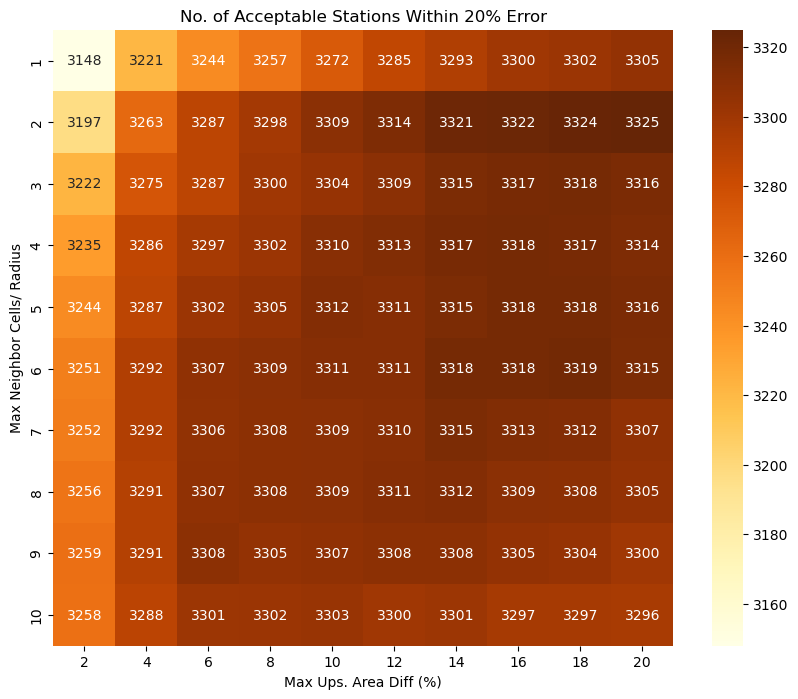

In [65]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the Count matrix
plt.figure(figsize=(10, 8))
sns.heatmap((count_df), annot=True, fmt=".0f", cmap="YlOrBr")
# plt.gca().invert_yaxis()  # Invert y-axis
plt.title(f'No. of Acceptable Stations Within {max_abs_error}% Error')
plt.xlabel('Max Ups. Area Diff (%)')
plt.ylabel('Max Neighbor Cells/ Radius')
plt.show()


Count of rows with absolute error % between manual_area and near_grid_area in the range of (0%, 20%): 2884 / 3697


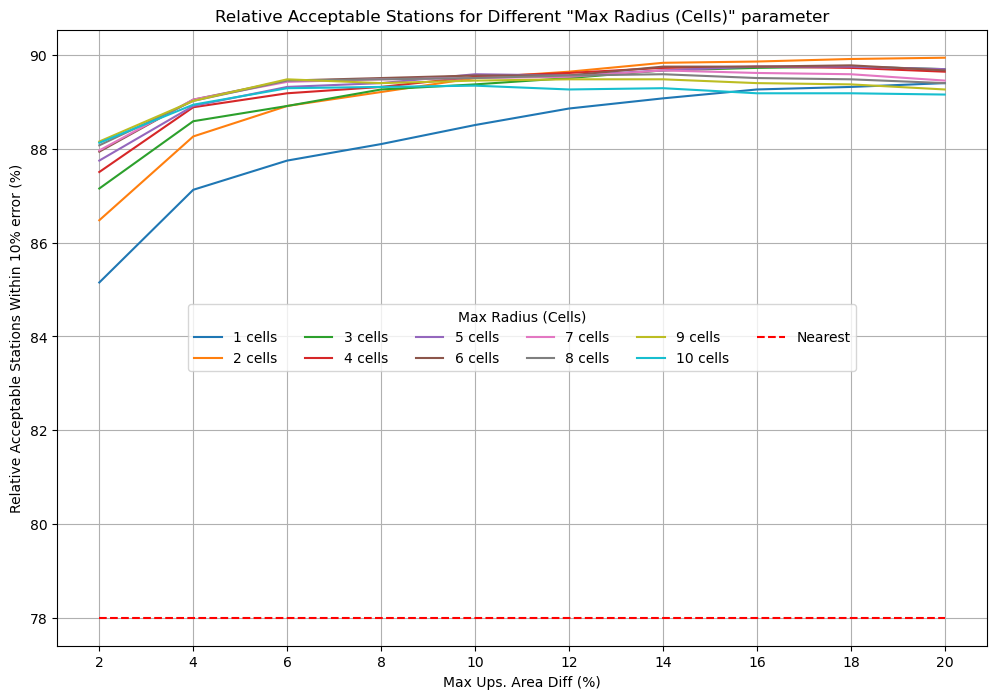

In [60]:
acceptable_count_near = count_within_abs_error_range(df, 'manual_area', 'near_grid_area', 0 , max_abs_error)

fig, ax = plt.subplots(figsize=(12, 8))

# Iterate over each row in count_df to plot
for max_cells in count_df.index:
    ax.plot(count_df.columns, count_df.loc[max_cells]/3697*100, label=f"{max_cells} cells")

# Adding the single value as a horizontal line
ax.hlines(acceptable_count_near/3697*100, xmin=min(max_diff_range), xmax=max(max_diff_range), 
          colors='red', linestyles='dashed', label='Nearest')

# Set the x-axis ticks to match max_diff_range
ax.set_xticks(list(max_diff_range))
# Adding grid
ax.grid(True)
ax.legend(title='Max Radius (Cells)', loc='center', ncol = 6)

plt.title('Relative Acceptable Stations for Different "Max Radius (Cells)" parameter')
plt.xlabel('Max Ups. Area Diff (%)')
plt.ylabel(f'Relative Acceptable Stations Within 10% error (%)')
plt.show()
